# CS 427 Project 3
Matthew Smith

Professor Jiang Li

Data Science

3 May 2024

In [1]:
# Import statements
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf

# Data Collection and Encoding

The data used in this project is the [NIST Handprinted Forms and Characters Database, 2nd Edition](https://www.nist.gov/srd/nist-special-database-19), from September 2016. It contains 814,255 images of handwritten alphanumeric characters from over 3,600 different writers. Included in the data set are all uppercase and lowercase English characters and the numbers 0 through 9.

Before this data can be used, the images must be converted to a format readable by a program. To do this, I converted the pictures to flattened one-dimensional arrays of values between 0 and 1, representing how dark a pixel was.

At the original image size of 128x128, this would have meant each row would have 16,384 columns plus a label. This was too large to work with, so I wrote an algorithm to intelligently crop each image and reduce its size to 32x32, so each row would have just 1,024 columns and a label.

## Encoding Algorithm
The cropping and resizing algorithm is shown below.

Note that this and the contents of the next few code blocks could not be performed on Colab due to the massive size of the data being worked with, so I performed it locally on my computer. Therefore, the functions are left in this Jupyter notebook but are not runnable. To run the algorithm below, I called `read_files()` with the dataset in my project directory.

In [2]:
from PIL import Image

def get_pixels(img: "Image") -> "np.ndarray":
  """
  Get one-dimensional numpy array of pixels as values from 0 to 1,
  with 1 being black and 0 being white.
  :param img: Image whose pixels will be converted
  :return: Array of pixels
  """
  return np.array([(255 - px) / 255 for px in img.getdata()])


def normalize(img: "Image", dims: "int") -> "Image":
  """
  Normalize an image by centering it within square bounds and
  resizing it.
  :param img: Image to be normalized
  :param dims: Dimensions of square image
  :return: Normalized image
  """
  img = img.convert("L")          # convert image to grayscale
  bounds = get_bounds(img)        # get image bounds
  img = img.crop(bounds)          # crop image to bounds
  img = pad(img, 0.25)            # pad image to square
  img = img.resize((dims, dims))  # resize image
  return img


def get_bounds(img: "Image") -> "tuple[int, int, int, int]":
  """
  Get the bounding box of a grayscale image, cropping out all
  white pixels.
  :param img: Image whose bounding box will be calculated
  :return: A tuple of coordinates in the format (left, top, right, bottom)
  """
  dims = max(img.size)    # get max of width and height
  pixels = np.array(img)  # get matrix of pixels with values 0...255

  # (leftmost_nonwhite, topmost_nonwhite, rightmost_nonwhite, bottommost_nonwhite)
  coordinates = np.array([dims, dims, 0, 0])

  for row in range(len(pixels)):
    for col in range(len(pixels[row])):
      if pixels[row][col] != 255:
        if col < coordinates[0]:
          # current pixel is farther left than leftmost pixel
          coordinates[0] = col

        if row < coordinates[1]:
          # current pixel is higher than topmost pixel
          coordinates[1] = row

        if col > coordinates[2]:
          # current pixel is farther right than rightmost pixel
          coordinates[2] = col

        if row > coordinates[3]:
          # current pixel is lower than bottommost pixel
          coordinates[3] = row

  # adjust bounds to include bottommost row and rightmost column
  coordinates[2] += 1
  coordinates[3] += 1

  return tuple(coordinates)


def pad(img: "Image", amt: "float" = 0) -> "Image":
  """
  Pad an image to be a square with extra padding
  specified by amt.
  :param img: Image to be padded
  :param amt: Value between specifying amount of extra padding
              relative to dimensions of the image
  :return: Square image with additional padding
  """
  width, height = img.size            # get width and height
  new_dims = max(width, height)       # make image square
  padding = int(2 * amt * new_dims)   # pad image
  new_dims += padding                 # add padding to new dimensions

  # make new image with new dimensions
  result = Image.new(img.mode, (new_dims, new_dims), 255)

  # get top-left coordinates for pasting image
  if max(img.size) == width:
    left = int(padding / 2)
    top = int(((width - height) / 2) + padding / 2)
  else:
    left = int(((height - width) / 2) + (padding / 2))
    top = int(padding / 2)

  # paste image in center
  result.paste(img, (left, top))
  return result


def read_files() -> None:
  """
  Read data files recursively.
  NOTE: The "test" and "training" sets referred to here are
  redundant and only one file is used in this notebook.
  """
  import os

  # define dictionary
  train_data = {f"{i}": [] for i in range(32 ** 2)}
  train_data["label"] = []

  test_data = {f"{i}": [] for i in range(32 ** 2)}
  test_data["label"] = []

  first_run = True

  count = 0  # Count is stored for visual indicator of progress

  for root, dirs, files in os.walk("./by_class"):
    for name in files:
      count += 1
      print(count)
      abs_path = os.path.join(root, name)     # absolute path as a string

      # skip .mit files
      if os.path.splitext(abs_path)[1] == ".mit":
        continue

      path = root.split(os.sep)               # file path as a list
      current_char = chr(int(path[1], 16))    # label of image
      img = Image.open(abs_path)              # get image
      img = normalize(img, 32)                # normalize image
      pixels = get_pixels(img)                # get pixels of image

      if name[0] == 't':
        # image is from training data
        for i in range(len(pixels)):
          train_data[str(i)].append(pixels[i])

        train_data["label"].append(current_char)
      else:
        # image is from testing data
        for i in range(len(pixels)):
          test_data[str(i)].append(pixels[i])

        test_data["label"].append(current_char)

    df_train = pd.DataFrame.from_dict(train_data)
    df_test = pd.DataFrame.from_dict(test_data)

    if first_run:
      df_train.columns = [f"pixel{row}-{col}" for row in range(32) for col in range(32)] + ["label"]
      df_test.columns = [f"pixel{row}-{col}" for row in range(32) for col in range(32)] + ["label"]

      df_test.to_csv("test.csv", mode='a', index=False)
      df_train.to_csv("train.csv", mode='a', index=False)
    else:
      df_test.to_csv("test.csv", mode='a', index=False, header=False)
      df_train.to_csv("train.csv", mode='a', index=False, header=False)

    first_run = False

    for key in train_data:
      train_data[key].clear()

    for key in test_data:
      test_data[key].clear()

## Reducing File Size
This algorithm produced CSV files that were still several gigabytes too large to work with and which did not take advantage of reduced data sizes—each value was a `float64` between 0 and 1, which was more precision than necessary.

To reduce the file size, I converted the data values for each pixel back to integers between 0 and 255 so they could be stored in 8-bit unsigned integers.

I also used a function written by Kaggle user ArjanGroen to reduce the size of the file by making the data types as small as possible without loss of precision. The function can be found [here](https://www.kaggle.com/code/arjanso/reducing-dataframe-memory-size-by-65).

In [3]:
"""The reduce_mem_usage() function was written by Kaggle user ArjanGroen."""
def reduce_mem_usage(props):
  start_mem_usg = props.memory_usage().sum() / 1024 ** 2
  print("Memory usage of properties dataframe is :", start_mem_usg, " MB")
  NAlist = []  # Keeps track of columns that have missing values filled in.
  for col in props.columns:
    if props[col].dtype != object:  # Exclude strings

      # Print current column type
      print("******************************")
      print("Column: ", col)
      print("dtype before: ", props[col].dtype)

      # make variables for Int, max and min
      IsInt = False
      mx = props[col].max()
      mn = props[col].min()

      # Integer does not support NA, therefore, NA needs to be filled
      if not np.isfinite(props[col]).all():
        NAlist.append(col)
        props[col].fillna(mn - 1, inplace=True)

      # test if column can be converted to an integer
      asint = props[col].fillna(0).astype(np.int64)
      result = (props[col] - asint)
      result = result.sum()
      if result > -0.01 and result < 0.01:
        IsInt = True

      # Make Integer/unsigned Integer datatypes
      if IsInt:
        if mn >= 0:
          if mx < 255:
            props[col] = props[col].astype(np.uint8)
          elif mx < 65535:
            props[col] = props[col].astype(np.uint16)
          elif mx < 4294967295:
            props[col] = props[col].astype(np.uint32)
          else:
            props[col] = props[col].astype(np.uint64)
        else:
          if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
            props[col] = props[col].astype(np.int8)
          elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
            props[col] = props[col].astype(np.int16)
          elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
            props[col] = props[col].astype(np.int32)
          elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
            props[col] = props[col].astype(np.int64)

      # Make float datatypes 32 bit
      else:
        props[col] = props[col].astype(np.float32)

      # Print new column type
      print("dtype after: ", props[col].dtype)
      print("******************************")

  # Print final result
  print("___MEMORY USAGE AFTER COMPLETION:___")
  mem_usg = props.memory_usage().sum() / 1024 ** 2
  print("Memory usage is: ", mem_usg, " MB")
  print("This is ", 100 * mem_usg / start_mem_usg, "% of the initial size")
  return props, NAlist

def to_int() -> None:
  chunk_size = 10000

  rows_written = 0

  with open("test_small.csv", "a") as output:
    reader = pd.read_csv("test.csv", chunksize=chunk_size)

    for chunk in reader:
      chunk.iloc[:, :1024] = (chunk.iloc[:, :1024] * 255).astype("int")
      reduce_mem_usage(chunk)
      if rows_written == 0:
        # Only print header once
        chunk.to_csv(output, index=False)
      else:
        chunk.to_csv(output, index=False, header=False)

      rows_written += len(chunk)
      output.flush()

The file was still too big, so I used the parquet format to reduce the size of the file even further.

In [4]:
def csv_to_parquet() -> None:
  # Specify data types in dictionary
  dtype = {f"pixel{row}-{col}": "uint8" for row in range(32) for col in range(32)}
  dtype["label"] = "str"

  # Read as CSV, write as parquet
  df = pd.read_csv('test_small.csv', dtype=dtype)
  df.to_parquet('test_smaller.parquet')

After this, the data was small enough to be worked with on Colab.

# Loading, Normalizing, and Exploring the Data
The following code chunks load the data into Colab and display previews of the data.

In [5]:
from google.colab import drive
# Mount Drive
drive.mount("/content/drive", force_remount=True)

# Load file
handwriting = pd.read_parquet("/content/drive/MyDrive/Semester 2/CS 427/Project3/handwriting.parquet")

# Preview dataset
handwriting

Mounted at /content/drive


,pixel0-0,pixel0-1,pixel0-2,pixel0-3,pixel0-4,pixel0-5,pixel0-6,pixel0-7,pixel0-8,pixel0-9,...,pixel31-23,pixel31-24,pixel31-25,pixel31-26,pixel31-27,pixel31-28,pixel31-29,pixel31-30,pixel31-31,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
814250,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,z
814251,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,z
814252,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,z
814253,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,z


The following code chunk normalizes the data set so that the darkness of the pixels are a value between 0 and 1 instead of 0 and 255.

In [6]:
handwriting.iloc[:, :1024] = (handwriting.iloc[:, :1024] / 255).astype(np.float16)
handwriting

,pixel0-0,pixel0-1,pixel0-2,pixel0-3,pixel0-4,pixel0-5,pixel0-6,pixel0-7,pixel0-8,pixel0-9,...,pixel31-23,pixel31-24,pixel31-25,pixel31-26,pixel31-27,pixel31-28,pixel31-29,pixel31-30,pixel31-31,label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
814250,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,z
814251,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,z
814252,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,z
814253,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,z


Each row in the dataset is essentially a flattened 2D array of pixels from an image. The values correspond to the color of each pixel—a value of 0 is white, a value of 1 is black, and anything in between is gray. The images have been reduced to 32 by 32, so each row contains 1024 pixels and a label.

The code below shows how a row can be interpreted into an image.

Character label: 0


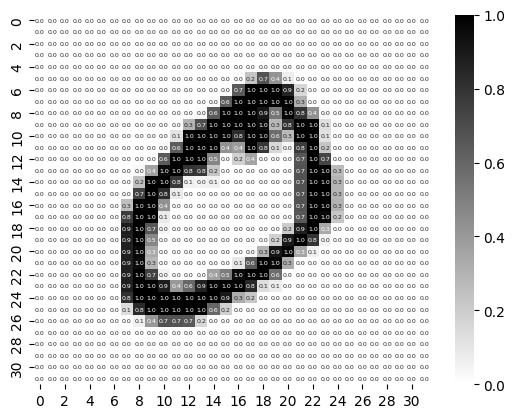

In [7]:
def show_image(row: "pd.Series", annot: "bool"=False) -> None:
  """
  Display an image based on the values of a series of length 1024.
  """
  arr = np.array(row.to_numpy()[0:1024], dtype=np.float16)
  arr = np.reshape(arr, (-1, 32))  # make into 32x32 2D array
  print("Character label:", row[-1])
  sns.heatmap(arr, annot=annot, annot_kws={"fontsize":4.5}, fmt=".1f", cmap="gray_r")


show_image(handwriting.iloc[0], True)

It is also important to understand the contents of the data set. Looking at a bar graph, we notice that the data set contains many samples of numeric characters as well as the letters `O`, `S`, `e`, `l`, `r`, and `t`. Some characters with fewer samples include `w`, `x`, `y`, `z`, and many other lowercase letters.

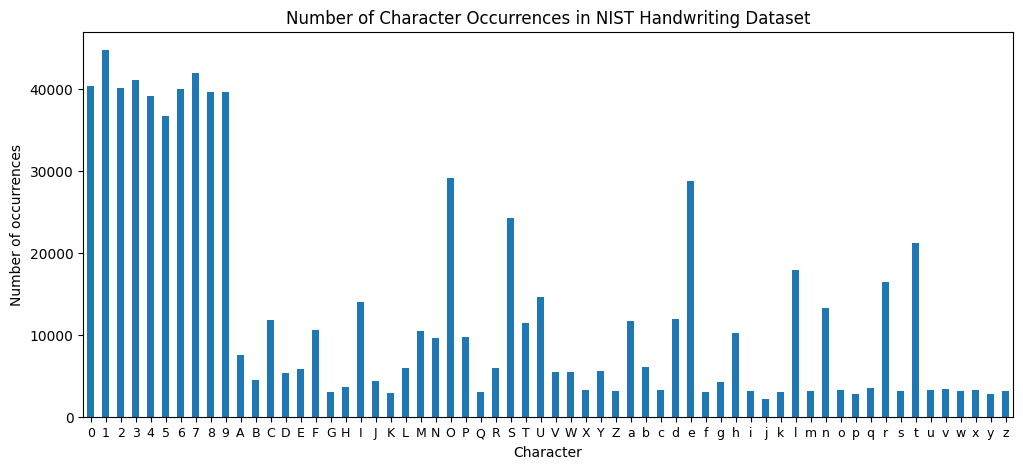

In [8]:
handwriting.groupby("label").size().plot.bar(figsize=(12, 5))
plt.xlabel("Character")
plt.xticks(fontsize=9, rotation=0)
plt.ylabel("Number of occurrences")
plt.title("Number of Character Occurrences in NIST Handwriting Dataset")
plt.show()

# Splitting Into Training and Testing Sets

The first step for splitting the data set into training and testing sets is to shuffle it.

In [9]:
# Shuffle data set
handwriting = handwriting.sample(frac=1).reset_index(drop=True)

# Preview data set
handwriting

,pixel0-0,pixel0-1,pixel0-2,pixel0-3,pixel0-4,pixel0-5,pixel0-6,pixel0-7,pixel0-8,pixel0-9,...,pixel31-23,pixel31-24,pixel31-25,pixel31-26,pixel31-27,pixel31-28,pixel31-29,pixel31-30,pixel31-31,label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,l
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,S
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,H
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
814250,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,n
814251,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7
814252,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
814253,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,N


Character label: l


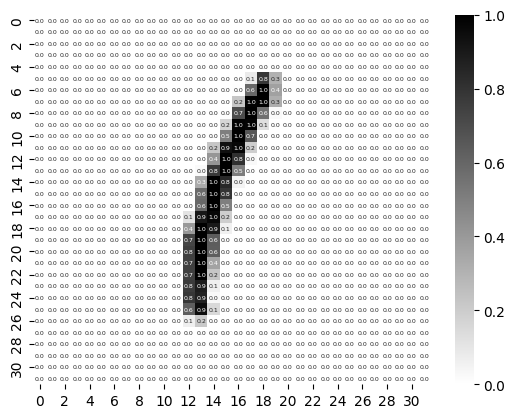

In [10]:
# Show entry at index 0 to demonstrate shuffled data set
show_image(handwriting.iloc[0], True)

Next, the data set will be split into training and testing sets.

In [11]:
test_split = 0.8  # Proportion of data set in training set
split_index = int(len(handwriting) * test_split)

# Split data set
handwriting_train = handwriting[:split_index].reset_index(drop=True)
handwriting_test = handwriting[split_index:].reset_index(drop=True)

# Show split
print("Training set length:", len(handwriting_train))
print("Testing set length:", len(handwriting_test))

Training set length: 651404
Testing set length: 162851


The training and testing sets are then split into features (the values for each pixel) and labels (the character depicted in the picture).

In [12]:
# Split training set
x_train = handwriting_train.iloc[:, :1024]
y_train = handwriting_train.iloc[:, -1]

print("x_train shape:", x_train.shape, "\ny_train shape:", y_train.shape)

# Split testing set
x_test = handwriting_test.iloc[:, :1024]
y_test = handwriting_test.iloc[:, -1]

print("\nx_test shape:", x_test.shape, "\ny_test shape:", y_test.shape)

x_train shape: (651404, 1024) 
y_train shape: (651404,)

x_test shape: (162851, 1024) 
y_test shape: (162851,)


Next, the labels must be converted to integers between 0 and 61 for use in the machine learning model. To do this, a list will be defined that maps `0` through `9` to indices 0 through 9, `A` through `Z` (uppercase) to indices 10 through 35, and `a` through `z` (lowercase) to indices 36 to 61.

In [13]:
# Define list
label_list =  [f'{i}' for i in range(10)]           # 0 - 9
label_list += [chr(i + 55) for i in range(10, 36)]  # A - Z
label_list += [chr(i + 61) for i in range(36, 62)]  # a - z

# Output list
print(label_list)

# Define functions for going between list value and actual value
def char_to_num(ch: "str | int") -> "int":
  """
  Convert a character 0-9, a-z, or A-Z into a value
  between 0 and 61.
  """
  return label_list.index(ch)

def num_to_char(num: "int") -> "str":
  """
  Convert a number 0-61 to its respective
  alphanumeric value from the list.
  """
  return label_list[num]

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [14]:
# Map labels to list indices
y_train = y_train.map(char_to_num)
y_test = y_test.map(char_to_num)

# Display converted dataframe
y_train.head()

0    47
1    28
2     6
3     5
4    17
Name: label, dtype: int64

# Creating a Deep Neural Network

Our goal is to use this data set to train a machine learning model to read a handwritten character and correctly identify it. This is a multi-class classification problem. I will use a deep neural network, since they tend to demonstrate high accuracy in computer vision problems.

A neural network is a type of machine learning model that consists of many layers, which in turn consist of neurons. In the case of our classification problem, it will have one input layer (where image data will go), one output layer (where the predicted character will go), and any number of hidden layers between it.

The neurons in each layer send a "signal" to the nodes in the next layer that is calculated by applying a nonlinear function on the sum of its inputs. The signal is multiplied by some weight, which is learned by the model. This allows the model to learn nonlinear features.

A neural network is classified as "deep" when it uses multiple hidden layers.

In a multiclass classification problem such as this one, the Softmax function assigns a probability between 0 and 1 to each of the possible output classes; these values must add up to 1. For example, if the model produces a value of 0.83 for the class `f`, it is 83% confident that the input image depicts a lowercase f.

## Metric Visualization
The code below defines a function that will visualize classification metrics for each epoch during model training.

In [15]:
def plot_curve(epochs, hist, metrics):
  """
  Plot a curve of one or more classification metrics by epoch.
  """
  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Value")

  # Plot each metric
  for m in metrics:
    x = hist[m]
    plt.plot(epochs[1:], x[1:], label=m)

  plt.legend()

## Creating the Model
The code below defines two functions for creating and training a TensorFlow neural network.

In [16]:
def create_model(layers: "list", learning_rate: "float",
                 dropout_rate: "float") -> "tf.keras.Model":
  """
  Create a neural network.
  """
  # Define sequential model
  model = tf.keras.models.Sequential()

  # Add hidden layers
  for num_neurons in layers:
    model.add(tf.keras.layers.Dense(units=num_neurons, activation="relu"))

  # Dropout regularization layer
  model.add(tf.keras.layers.Dropout(rate=dropout_rate))

  # Output layer
  # 62 neurons are used to represent 26 lowercase characters, 26
  # uppercase characters, and 10 numeric characters
  model.add(tf.keras.layers.Dense(units=62, activation="softmax"))

  # Compile model
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                loss="sparse_categorical_crossentropy",
                metrics=["accuracy"])

  return model


def train_model(model: "tf.keras.Model", features: "pd.DataFrame",
                labels: "pd.DataFrame", num_epochs: "int",
                validation_split: "float", batch_size: "int"=None) -> "tuple":
  """
  Train a model.
  """
  # Train model and get model history
  history = model.fit(x=features, y=labels, batch_size=batch_size,
                      epochs=num_epochs, shuffle=True,
                      validation_split=validation_split)

  # Get model metrics at each epoch
  epochs = history.epoch
  hist = pd.DataFrame(history.history)

  return epochs, hist

## Training the Model
Finally, the code below creates and trains the neural network. The hyperparameters are located at the top as separate variables for easily accessible fine-tuning.

Epoch 1/40
27/27 [==============================] - 23s 793ms/step - loss: 2.8882 - accuracy: 0.3098 - val_loss: 1.7606 - val_accuracy: 0.5675
Epoch 2/40
27/27 [==============================] - 19s 698ms/step - loss: 1.6939 - accuracy: 0.5680 - val_loss: 1.1738 - val_accuracy: 0.6770
Epoch 3/40
27/27 [==============================] - 20s 763ms/step - loss: 1.2488 - accuracy: 0.6540 - val_loss: 0.8976 - val_accuracy: 0.7311
Epoch 4/40
27/27 [==============================] - 26s 989ms/step - loss: 1.0182 - accuracy: 0.7032 - val_loss: 0.7728 - val_accuracy: 0.7585
Epoch 5/40
27/27 [==============================] - 18s 680ms/step - loss: 0.8918 - accuracy: 0.7314 - val_loss: 0.6949 - val_accuracy: 0.7758
Epoch 6/40
27/27 [==============================] - 20s 746ms/step - loss: 0.8117 - accuracy: 0.7501 - val_loss: 0.6501 - val_accuracy: 0.7864
Epoch 7/40
27/27 [==============================] - 19s 706ms/step - loss: 0.7569 - accuracy: 0.7629 - val_loss: 0.6195 - val_accuracy: 0.7937

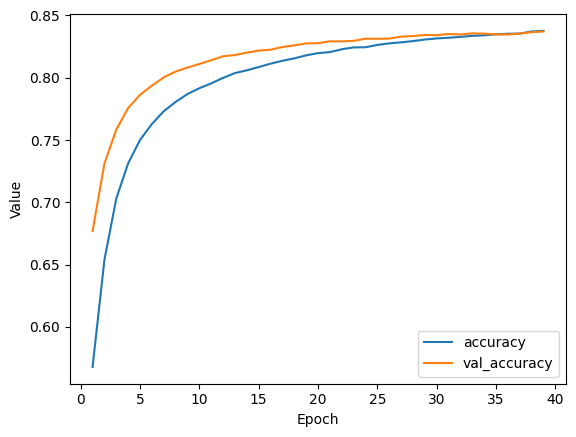

In [17]:
# Hyperparameters
learning_rate = 0.002
num_epochs = 40
batch_size = 20000
validation_split = 0.2
layers = [256, 128, 64]
dropout_rate = 0.35

# Create model
model = create_model(layers, learning_rate, dropout_rate)

# Train model
epochs, hist = train_model(model, x_train, y_train, num_epochs,
                           validation_split, batch_size)

# Plot loss curve
metrics = ["accuracy", "val_accuracy"]
plot_curve(epochs, hist, metrics)

# Evaluating the Model

There are several measures we can use to evaluate the effectiveness of the model. First, a simple accuracy measure tells us what proportion of the predictions it made on the test set were correct.

In [18]:
# Evaluate model against test set
print("Accuracy of model on testing set:")
model.evaluate(x=x_test, y=y_test, batch_size=batch_size)

Accuracy of model on testing set:
9/9 [==============================] - 2s 246ms/step - loss: 0.4504 - accuracy: 0.8398


[0.4504275918006897, 0.8397921919822693]

Next, we look at the probability values from the Softmax function that the model predicted for each character in the testing set. We assume that the class with the highest probability is the label that the model predicts for that character.

In [19]:
# Get predictions for test set
probabilities = model.predict_on_batch(x_test)

# Display Softmax probabilities for first character in testing set
print("Probabilities for first character:\n", probabilities[0])
print("The model predicts", num_to_char(np.argmax(probabilities[0])))

Probabilities for first character:
 [5.81767620e-12 3.82211320e-12 9.99920666e-01 8.10176926e-10
 9.61930341e-15 8.39087355e-15 1.26046454e-15 1.20051746e-09
 9.77921855e-10 1.07148856e-11 2.58683873e-11 4.91135886e-13
 1.66300224e-10 1.20187763e-10 5.92653877e-12 6.22628034e-13
 7.64494457e-12 1.87535725e-17 1.30291123e-12 1.09813955e-11
 1.52230680e-17 5.25820880e-12 3.66690388e-15 8.29585012e-12
 4.83172443e-12 3.21455712e-14 1.41371705e-08 1.06315323e-09
 1.60531727e-10 3.38024042e-13 1.08243345e-10 1.91504310e-13
 1.11010691e-12 2.01679453e-13 3.77109639e-13 6.66278083e-07
 7.44592398e-05 6.91382105e-14 1.11531565e-11 6.63081380e-07
 2.28192923e-10 2.46387925e-13 4.75786806e-08 1.61115746e-14
 2.78939066e-10 1.93864300e-11 1.99030137e-16 1.35721610e-12
 5.01859974e-14 6.86491072e-11 3.66767706e-13 8.67971873e-14
 1.63968092e-08 2.16782647e-10 3.48728546e-11 6.30547090e-12
 4.29509683e-12 8.82668938e-13 1.25218586e-11 3.39579198e-11
 1.46411593e-14 3.42222506e-06]
The model predict

We can use the predictions made by the model to create a confusion matrix. This shows all of the actual characters in the testing set (y-axis) compared to what the model believed the characters to be based on the input features (x-axis).

By examining the confusion matrix, we can see where the model predicted incorrectly. The vast majority of incorrect predictions were concentrated in letters and numbers that look indistinguishable, such as `0`, `O`, and `o`, and `1,` `I`, and `l`.

It can also be seen that uppercase letters were sometimes confused for their respective lowercase letters, and lowercase letters were sometimes confused for their respective uppercase characters.

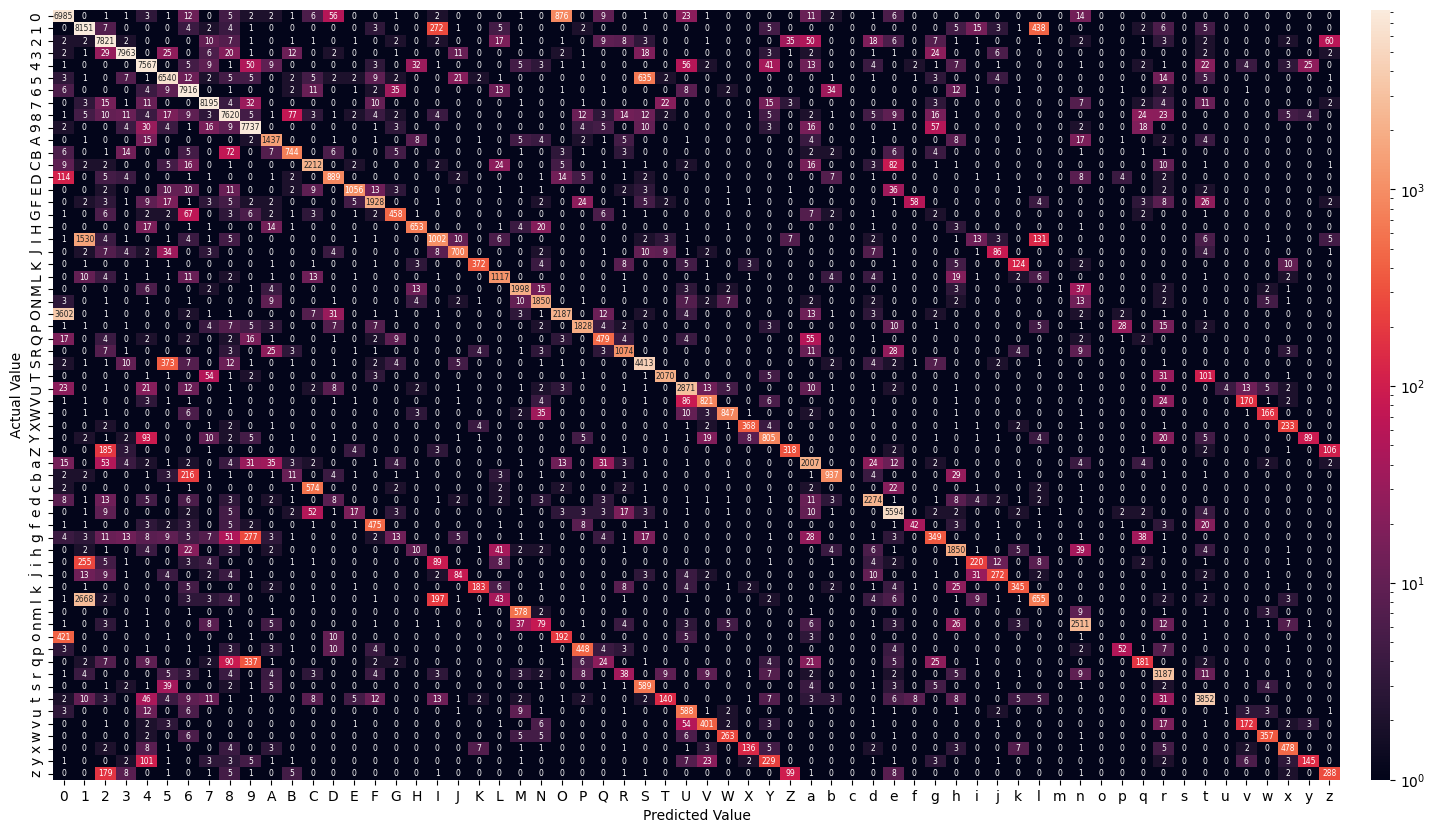

In [50]:
from sklearn.metrics import confusion_matrix
from matplotlib.colors import LogNorm

# Get max probability from each prediction
predictions = np.array([np.argmax(arr) for arr in probabilities])

# Create confusion matrix from predictions
cm = confusion_matrix(y_test, predictions, labels=[i for i in range(62)])

# Plot confusion matrix
plt.figure(figsize=(20, 10))
sns.heatmap(cm, annot=True, annot_kws={"fontsize":5.5}, fmt="g", cbar=True,
            xticklabels=label_list, yticklabels=label_list,
            norm=LogNorm(clip=True), cbar_kws={"aspect": 40, "pad": 0.02})
plt.xlabel("Predicted Value")
plt.ylabel("Actual Value")
plt.show()

Next, we can look at some randomly chosen examples of classifications that the model got wrong. We first get the indices of all incorrect predictions from the test set, then display a sample of the incorrectly classified images, their labels, and the model's (incorrect) prediction.

In [21]:
# Get indices of incorrect predictions
incorrect_predictions = np.array([i for i in range(len(predictions)) if predictions[i] != y_test.iloc[i]])
print(incorrect_predictions)
print("Number of incorrect predictions on the test set:", len(incorrect_predictions))

[     2      9     21 ... 162830 162841 162845]
Number of incorrect predictions on the test set: 26090


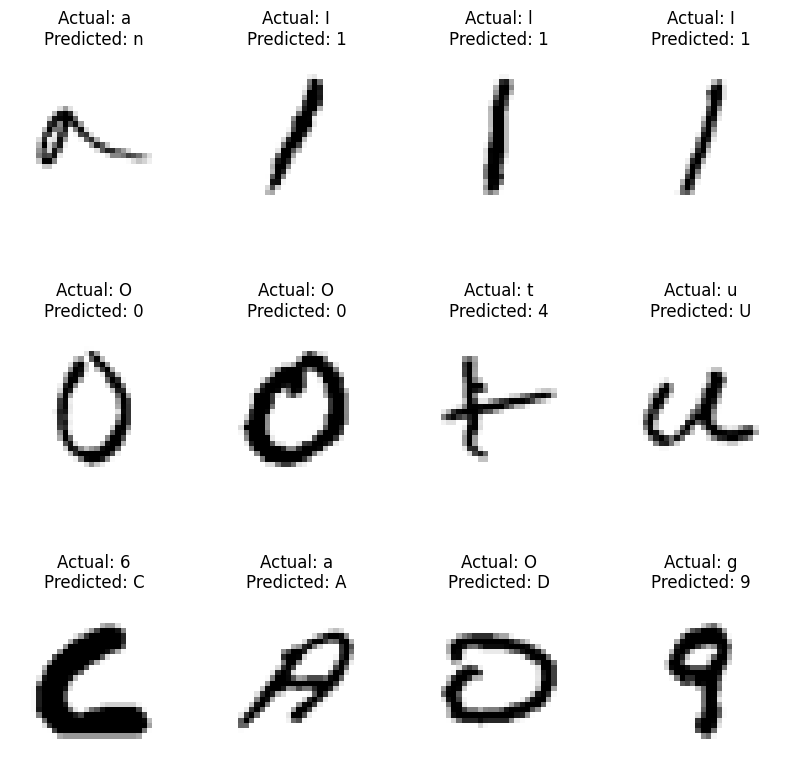

In [22]:
# Define number of rows and columns in figure
NUM_ROWS = 3
NUM_COLS = 4

# Get random indices of incorrect predictions
random_indices = np.array([np.random.choice(incorrect_predictions) for i in range(NUM_ROWS * NUM_COLS)])

plt.figure(figsize=(10, 10))

for count, index in enumerate(random_indices):
  # Get actual and predicted values
  actual = num_to_char(y_test.iloc[index])
  predicted = num_to_char(predictions[index])

  # Make subplot
  plt.subplot(NUM_ROWS, NUM_COLS, count+1)
  plt.axis("off")
  plt.title(f"Actual: {actual}\nPredicted: {predicted}")

  # Create heatmap
  arr = np.array(x_test.iloc[index].to_numpy(), dtype = np.float16)
  arr = np.reshape(arr, (-1, 32))
  sns.heatmap(arr, cmap="gray_r", cbar=False, square=True)

plt.show()

The two most common errors seem to be confusing numbers for letters and letters for numbers, and confusing a letter with its respective uppercase or lowercase form. To see what proportion of the incorrect predictions are due to these two mistakes, we will count their occurrences.

In [23]:
# Count incorrect predictions for case mismatches and number-letter confusion
incorrect_case = 0
incorrect_num = 0

for pred_index in incorrect_predictions:
  if (
      # actual = lowercase, predicted = uppercase
      predictions[pred_index] + 26 == y_test[pred_index] or
      # actual = uppercase, predicted = lowercase
      predictions[pred_index] - 26 == y_test[pred_index]
    ):
    incorrect_case += 1
  elif (
      # actual = letter, predicted = number
      (y_test[pred_index] > 9 and predictions[pred_index] <= 9) or
      # actual = number, predicted = letter
      (y_test[pred_index] <= 9 and predictions[pred_index] > 9)
    ):
    incorrect_num += 1

num_combined_mistakes = incorrect_case + incorrect_num

print("Number of errors due to mismatched case:", incorrect_case)
print("Number of errors due to confusing letters with numbers:", incorrect_num)
print("Combined total from both mistakes:", num_combined_mistakes)

Number of errors due to mismatched case: 6718
Number of errors due to confusing letters with numbers: 15355
Combined total from both mistakes: 22073


In [24]:
# Get proportions of all incorrect predictions made with the specified errors
prop_incorrect_case = incorrect_case / len(incorrect_predictions)
prop_incorrect_num = incorrect_num / len(incorrect_predictions)
prop_combined_mistakes = num_combined_mistakes / len(incorrect_predictions)

print(f"Proportion of incorrect predictions due to mismatched case: {prop_incorrect_case:.3f}")
print(f"Proportion of incorrect predictions due to confusing letters with numbers: {prop_incorrect_num:.3f}")
print(f"Proportion of incorrect predictions due to both: {prop_combined_mistakes:.3f}")

Proportion of incorrect predictions due to mismatched case: 0.257
Proportion of incorrect predictions due to confusing letters with numbers: 0.589
Proportion of incorrect predictions due to both: 0.846


We can also see what the accuracy rate of the model would be assuming there were no case mismatches or letter-number confusions.

In [25]:
num_unrelated_mistakes = len(incorrect_predictions) - num_combined_mistakes
print(f"Number of incorrect predictions NOT due to mismatched case or confusing letters with numbers: {num_unrelated_mistakes}")
print(f"Not counting these errors, the accuracy rate would be {1 - (num_unrelated_mistakes / (len(predictions) - num_combined_mistakes)):.5f}")

Number of incorrect predictions NOT due to mismatched case or confusing letters with numbers: 4017
Not counting these errors, the accuracy rate would be 0.97147


# Further Testing of the Model

To test how well the model would generalize to data from outside the NIST data set, I scanned images of my own handwriting and had the model predict the character I wrote.

In [26]:
# Load data
my_handwriting = pd.read_parquet("/content/drive/MyDrive/Semester 2/CS 427/Project3/matthew_handwriting.parquet")

# Set to values between 0 and 1
my_handwriting.iloc[:, :1024] = (my_handwriting.iloc[:, :1024] / 255).astype(np.float16)

# Split into features and labels
x_my_handwriting = my_handwriting.iloc[:, :1024]
y_my_handwriting = my_handwriting.iloc[:, -1].map(char_to_num)

Character label: H


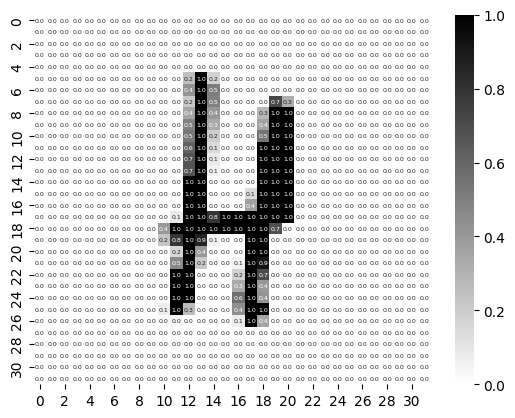

In [27]:
# Sample image of my handwriting
show_image(my_handwriting.iloc[17], True)

In [28]:
# Predict character in each picture
my_probabilities = model.predict_on_batch(x_my_handwriting)
my_predictions = np.array([np.argmax(arr) for arr in my_probabilities])
my_predictions

array([ 0, 47,  2,  3, 34,  5,  6,  7,  8,  9, 10,  8, 12, 13, 14, 15,  6,
       17, 18, 19, 20, 21, 22, 23,  0, 25, 26, 27,  5, 29, 30, 57, 32, 33,
       34, 35, 36, 37, 12, 39, 40, 15, 42, 43, 44, 45, 46, 47, 22, 49,  0,
       25,  9, 53, 28, 55, 30, 31, 32, 59, 34, 61])

In [29]:
# Evaluate model against test set
print("Accuracy of model on my handwriting:")
model.evaluate(x=x_my_handwriting, y=y_my_handwriting)

Accuracy of model on my handwriting:
2/2 [==============================] - 0s 7ms/step - loss: 0.6482 - accuracy: 0.7097


[0.6482067704200745, 0.7096773982048035]

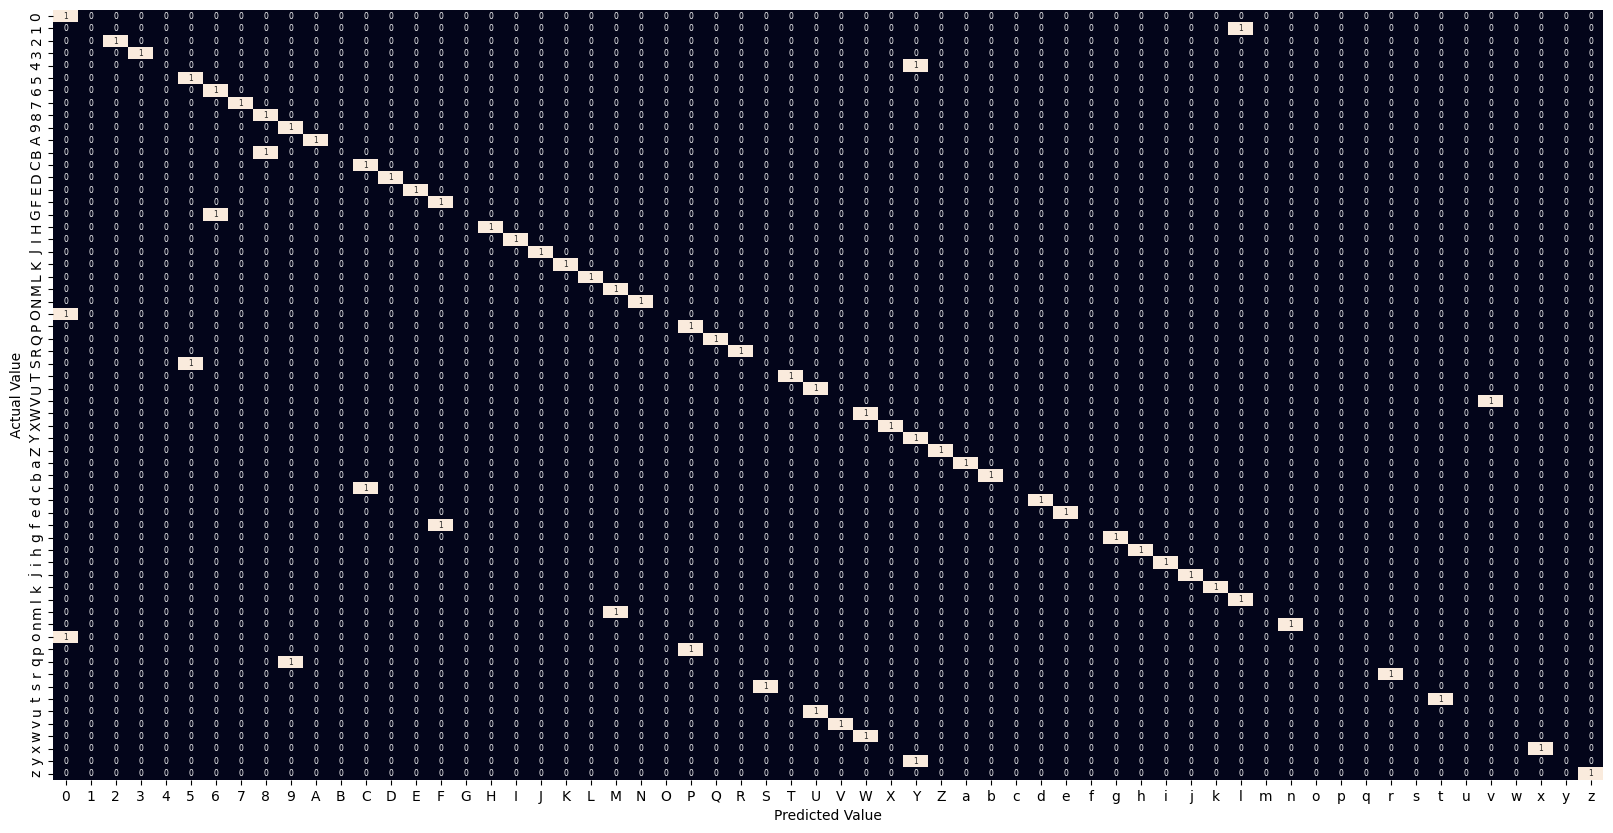

In [30]:
# Create confusion matrix from predictions
cm = confusion_matrix(y_my_handwriting, my_predictions, labels=[i for i in range(62)])

# Plot confusion matrix
plt.figure(figsize=(20, 10))
sns.heatmap(cm, annot=True, annot_kws={"fontsize":5.5}, fmt="g", cbar=False,
            xticklabels=label_list, yticklabels=label_list)
plt.xlabel("Predicted Value")
plt.ylabel("Actual Value")
plt.show()

In my testing, the accuracy of the model on my handwriting ranged from about 67 to 75 percent. It was consistently lower than the accuracy of the model on the testing set. There are two reasons I could think of for why this was the case:

1.   **Messy handwriting**

  The first factor is that my handwriting could just have been messier than the average sample in the data set. This may explain some, but not all, of the incorrect predictions.


2.   **Different scanning and normalization process**

  The second factor has to do with the process of taking a handwritten form and turning it into a series of scanned image files. What tools and software I used to get images of my handwriting are undoubtedly different from what the NIST used. For example, I noticed that the images from the NIST data set had much thicker strokes than mine, which may have been the result of using a coarser and less accurate scanner.

# Conclusion and Future Work

## Results

In my testing, the accuracy of the model on the testing set typically lied between 83% and 84% at best. In general, more epochs resulted in higher accuracy, but training the neural network took too long for anything over 40-50 epochs to be feasible.

If I were to pursue this subject further and try to raise the accuracy of the model, I would try using a convolutional neural network (CNN). This type of neural network has demonstrated great success with image classification and computer vision tasks in the past. A CNN takes input and groups neighboring features together in convolution layers that share weights. For the NIST data set, this would allow the model to take into account data in neighboring pixels.

Some of the inaccuracy resulted from the normalization I performed on the images. By cropping them such that they were centered in the middle of the image at a consistent size, I removed the disparities that distinguished some uppercase letters from lowercase letters. (For example, the only difference between `O` and `o` or `Z` and `z` is the size of the letter.) Additionally, due to reducing the resolution of the images by 75%, some of the letters' counters (openings enclosed by a letter, such as in `e` or `o`) were lost.

## Applications

Most of the incorrect predictions made by the model were due to confusing very similar or even indistinguishable characters, such as `O`, `o`, and `0`; `l`, `I`, and `1`; and `2`, `Z`, and `z`. There are two ways that this issue could be avoided in practice.

1.   **Different models for different input fields**

  When actually applying this model in the real world, one way to improve accuracy would be to use differently trained models depending on the field being read. For example, when reading the date field, assuming the date would be written in a format like `01/01/2000`, there is no reason to use a model trained on all alphanumeric characters. Most fields in forms use exclusively numbers or exclusively letters, so there would be no need to consider every possible alphanumeric character. An obvious exception is an email field, which can use any combination of alphanumeric characters.

  Confusing numbers with letters made up nearly 60% of the incorrect predictions made by the model, so this solution would remove nearly 60% of incorrect predictions.

2.   **Loss of case sensitivity**

  Many of the incorrect predictions made by the model stemmed from confusing uppercase and lowercase versions of the same letter. In most fields of a form, case sensitivity is nonessential. Therefore, although the model may incorrectly predict, for example, a `w` instead of a `W`, this mistake would be inconsequential if the final output of the model is always capitalized.

  Confusing uppercase and lowercase letters made up about 25% of the incorrect predictions made by the model, so this solution would remove about 25% of incorrect predictions.